In [22]:
import numpy as np
import math
import sklearn.linear_model
import sklearn.metrics

import time

from matplotlib import pyplot as plt
%matplotlib inline

import load
import cnn

In [3]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = load.get_sets()

In [4]:
cnn_train = cnn.get_cnn_features(train_ids)
cnn_val = cnn.get_cnn_features(val_ids)
cnn_test = cnn.get_cnn_features(test_ids)

In [5]:
class_weight=None # or 'balanced'

## CNN

In [4]:
n_C = 20
C_list = np.logspace(-10, 10, n_C)
errors = np.zeros(n_C)
for i, C in enumerate(C_list):
    model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C, class_weight=class_weight)
    t = time.time()
    model.fit(cnn_train, train_labels)
    print("LR took %f seconds."%(time.time()-t))
    predictions = model.predict(cnn_val)
    errors[i] = (val_labels!=predictions).sum()/len(val_labels)

LR took 3.400884 seconds.
LR took 5.516677 seconds.
LR took 6.415585 seconds.
LR took 9.939948 seconds.
LR took 16.784987 seconds.
LR took 32.170354 seconds.
LR took 70.057452 seconds.
LR took 144.294972 seconds.
LR took 175.825194 seconds.
LR took 178.448460 seconds.
LR took 184.788500 seconds.
LR took 191.470629 seconds.
LR took 185.888712 seconds.
LR took 191.946352 seconds.
LR took 175.684194 seconds.
LR took 180.971260 seconds.
LR took 198.568766 seconds.
LR took 195.690111 seconds.
LR took 189.387441 seconds.
LR took 190.308823 seconds.


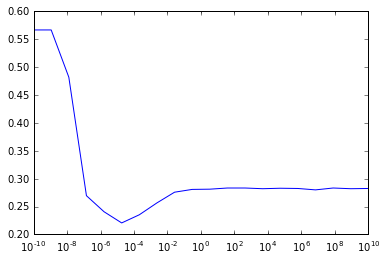

In [5]:
plt.plot(C_list, errors)
plt.xscale('log')

In [11]:
#i_opt = np.argmin(errors)
C_opt = 0.000018#C_list[i_opt]
print('optimal C : %f'%C_opt)
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C_opt, class_weight=class_weight)
t = time.time()
model.fit(cnn_train, train_labels)
print("LR took %f seconds."%(time.time()-t))
predictions = model.predict(cnn_test)
err = (test_labels!=predictions).sum()/len(test_labels)

optimal C : 0.000018
LR took 33.853372 seconds.


In [12]:
err

0.21041666666666667

In [13]:
cnn_proba_val = model.predict_proba(cnn_val)[:,:-1]
cnn_proba_test = model.predict_proba(cnn_test)[:,:-1]

## LR

In [14]:
l = 6
color = False
train_reduc, val_reduc, test_reduc = load.load_all_data(train_ids, val_ids, test_ids, l, color)

In [15]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10, class_weight=class_weight)
model.fit(train_reduc, train_labels)
predictions = model.predict(val_reduc)
error = (val_labels!=predictions).sum()/len(val_labels)
error

0.39966624947851481

In [16]:
reduc_proba_val = model.predict_proba(val_reduc)[:,:-1]
reduc_proba_test = model.predict_proba(test_reduc)[:,:-1]

In [17]:
val_mix = np.concatenate([cnn_proba_val, reduc_proba_val], axis=1)
test_mix = np.concatenate([cnn_proba_test, reduc_proba_test], axis=1)

In [18]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10, class_weight=class_weight)
model.fit(val_mix, val_labels)
predictions = model.predict(test_mix)
error = (test_labels!=predictions).sum()/len(test_labels)
error

0.19875000000000001

In [19]:
probas = model.predict_proba(test_mix)

## Confusion matrix

In [23]:
sklearn.metrics.confusion_matrix(test_labels, predictions)

array([[957,  22,  10,  51],
       [ 26, 426,  10,  69],
       [ 11,  20, 208,  23],
       [126,  86,  23, 332]])

## Confidence

In [39]:
confidence = np.max(probas, axis=1)

(array([  3.,   4.,   0.,   0.,   1.,   1.,   3.,   2.,   1.,   5.,   2.,
          2.,   3.,   3.,   6.,   3.,   5.,   6.,   8.,   4.,  15.,   6.,
         14.,  15.,  14.,  12.,  13.,  11.,  15.,   7.,  20.,   7.,  12.,
         18.,  14.,  12.,  12.,  15.,  17.,  18.,  16.,  16.,  11.,  19.,
         19.,  11.,  14.,  12.,  19.,  14.,  17.,  13.,  16.,  19.,  15.,
         21.,  20.,  17.,  16.,  16.,  17.,  18.,  26.,  17.,  19.,  27.,
         15.,  19.,  32.,  24.,  28.,  24.,  31.,  36.,  25.,  28.,  35.,
         27.,  42.,  30.,  35.,  39.,  57.,  44.,  40.,  65.,  57.,  49.,
         59.,  51.,  77.,  70.,  83.,  90.,  91.,  97.,  74.,  71.,  54.,
         27.]),
 array([ 0.34691441,  0.35302819,  0.35914196,  0.36525574,  0.37136951,
         0.37748329,  0.38359707,  0.38971084,  0.39582462,  0.40193839,
         0.40805217,  0.41416594,  0.42027972,  0.4263935 ,  0.43250727,
         0.43862105,  0.44473482,  0.4508486 ,  0.45696237,  0.46307615,
         0.46918992,  0.47

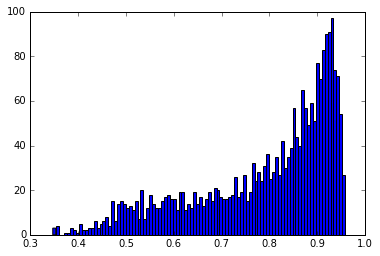

In [40]:
plt.hist(confidence, bins=100)

In [41]:
N = len(confidence)
confidence_order = np.argsort(-confidence)
sorted_error = (predictions[confidence_order]!=test_labels[confidence_order])
nb_errors = np.cumsum(sorted_error)
error_rate = nb_errors/np.arange(N)

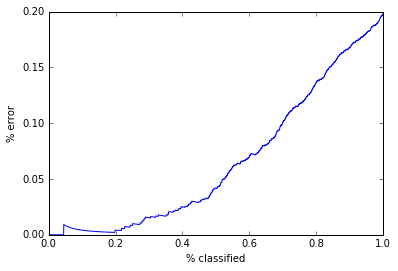

In [42]:
plt.plot(np.arange(N)/N, error_rate)
plt.xlabel('% classified')
plt.ylabel('% error')

In [43]:
def custom_convolution(a, kernel):
    n = len(a)
    k = int((len(kernel)-1)/2)
    
    conv = np.zeros(n)
    for i in range(n):
        imin_kernel = max(0, k-i)
        imax_kernel = min(2*k+1, k+n-i)
        imin_a = max(0, i-k)
        imax_a = min(n, k+1+i)
        conv[i] = (a[imin_a:imax_a]*kernel[imin_kernel:imax_kernel]).sum() / (kernel[imin_kernel:imax_kernel].sum())
    
    return conv

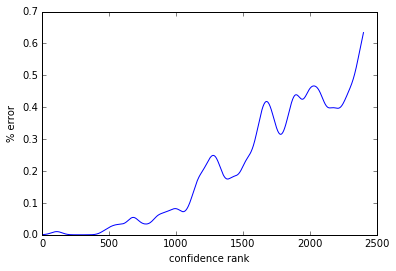

In [47]:
sigma = 40.
kernel_size = int(math.floor(3.5*sigma))
kernel = np.exp(-np.power(np.arange(2*kernel_size+1)-kernel_size, 2.)/(2*np.power(sigma, 2.)))
kernel /= kernel.sum()

smooth_error = custom_convolution(sorted_error, kernel)
plt.figure()
plt.plot(smooth_error)
plt.xlabel('confidence rank')
plt.ylabel('% error')